# Radiation model for comparison/calibration

1 Use geostat to generate travel demand based on Radiation model

2 Compare Radiation model output with Sampers

3 Try calibrate against Radiation model output and compare it with Sampers

In [1]:
%load_ext autoreload
%autoreload 2

In [21]:
# Load libs
import numpy as np
import pandas as pd
import pprint

import radiation
import models
import sampers
import genericvalidation
import netherlands
import plots

## 1 Get population in zones
Travel demand of residents in eastern Sweden, western Sweden, national Sweden, and the Netherlands.

In [34]:
r = 'netherlands'
pprint.pprint(radiation.zones)

# get pop via ssp file
zones = radiation.get_pop_ssp(radiation.zones, r)
zones = zones.loc[zones.zone != 0, :]

# get centroids
zones.loc[:, 'X'] = zones.centroid.x
zones.loc[:, 'Y'] = zones.centroid.y

{'netherlands': <function zones at 0x0000029F2350D510>,
 'sweden_east': '../../dbs/sampers/east/region.shp',
 'sweden_national': '../../dbs/sampers/national/region.shp',
 'sweden_west': '../../dbs/sampers/west/region.shp'}


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:15: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  from ipykernel import kernelapp as app
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:16: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  app.launch_new_instance()


## 2 Radiation modelling

In [35]:
# Haversine distance matrix between zone centroids
d = radiation.haversine_vec(list(zones.loc[:, ["Y", "X"]].values))
np.save(f'../../dbs/radiation_model_output/{r}_d', d)

In [36]:
# flows by Radiation model
T = radiation.radiation(d, zones['pop'].values / 1000)
np.save(f'../../dbs/radiation_model_output/{r}_flows', T)

D:\individual-mobility-model\lib\radiation.py:89: RuntimeWarning: invalid value encountered in true_divide
  return flows


## 3 IMM model output

In [22]:
gtpath = "../../dbs/sweden/geotweets.csv"

visit_factory = models.Sampler(
    model=models.PreferentialReturn(
        p=.4,
        gamma=.75,
        region_sampling=models.RegionTransitionZipf(beta=.03, zipfs=1.2),
    ),
    n_days=7 * 20,
    daily_trips_sampling=models.NormalDistribution(mean=3.14, std=1.8),
    geotweets_path=gtpath,
)
visits = visit_factory.visits()
visits.head()
df_t_odm = genericvalidation.visits_to_odm(visits, zones)

done with 250
done with 500
done with 750
done with 1000
done with 1250
done with 1500
done with 1750
done with 2000
done with 2250
done with 2500
done with 2750
done with 3000
done with 3250
done with 3500
Convering visits to zone CRS
Aligning region-visits to zones...
removed 13740 region-visits due to missing zone geom
Aligning point-visits to zones...
removed 10831 point-visits due to missing zone geom
2108370 visits left after alignment
Creating odm...


## 4 Compare Sampers, Radiation model output, and IMM output

In [16]:
# load sampers (from lib/validation.py)
if r.split('_')[0] == 'sweden':
    odm = sampers.read_odm(sampers.odms[r.split('_')[1]]).set_index(['ozone', 'dzone'])['total']
    print("zones", zones.shape)
    print("odm", odm.shape, odm.sum())

    # ODM file can contain trips between zones that are not actually part of the scale.
    # Drop trips between unknown zones and
    # insert 0.0 trips between zones that are not represented in ODM
    print("Reindexing...")
    zonesx = zones.set_index('zone')
    odm = odm.reindex(
        pd.MultiIndex.from_product([
            zonesx.index,
            zonesx.index,
        ]),
        fill_value=0.0,
    )
    print("odm", odm.shape)
    odm = odm / odm.sum()
else:
    odm = netherlands.odm()

zones (3037, 8)
odm (9253764,) 4982573.000714299
Reindexing...
odm (9223369,)


In [17]:
# matrix2zone dict
zone_dict = {x: y for x,y in zip(range(0, len(zones)), zones.zone.values)}
# convert flows by Radiation model into the same form
df_T = pd.DataFrame(T)
df_T = df_T.unstack().reset_index()
df_T.columns = ['ozone', 'dzone', 'total']
df_T.ozone = df_T.ozone.map(zone_dict)
df_T.dzone = df_T.dzone.map(zone_dict)
df_T.loc[:, 'total'] = df_T.loc[:, 'total'].fillna(0)
df_T = df_T.set_index(['ozone', 'dzone'])['total']
df_T = df_T / df_T.sum()

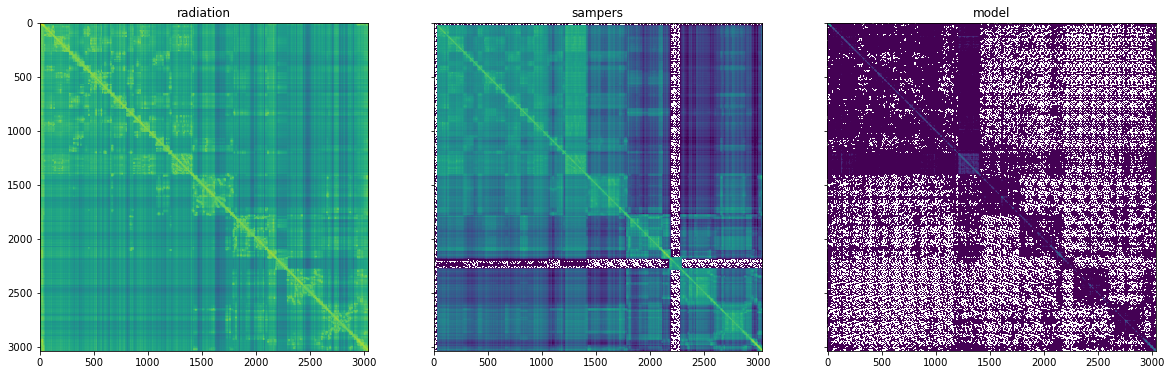

In [23]:
odmfig = plots.plot_odms(
    [
        df_T,
        odm,
        df_t_odm
    ],
    ['radiation', 'sampers', 'model'],
)

## 4 Quantify the similarity between Radiation model and IMM (as calibrated against Sampers)

In [27]:
# similarity
from scipy import spatial
cos_simi = 1 - spatial.distance.cosine(df_T, df_t_odm)
print(cos_simi)

0.8680565635138915
